In [22]:
%load_ext autoreload
%autoreload 2
from time import time
import matplotlib.pyplot as plt
import numpy as np

from bosonicplus.interferometers.parameters import gen_interferometer_params
from bosonicplus.interferometers.construct import build_interferometer
from bosonicplus.measurements.photon_counting import post_select_fock_coherent


from thewalrus.symplectic import two_mode_squeezing, squeezing, beam_splitter,expand, xxpp_to_xpxp
from strawberryfields.backends.bosonicbackend.bosoniccircuit import BosonicModes

from bosonicplus.wavefunction import post_select_fock_pure, get_prob



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Do a photon measurement on a Gaussian pure state

In [42]:
## Make an two-mode squeezed state

num = 2
r = 1
idx = 0

S = expand(two_mode_squeezing(r,0),[0,1],num)
    
    
sigma_xxpp = np.array([S@np.eye(num*2)@S.T])
sigma = np.array([xxpp_to_xpxp(i) for i in sigma_xxpp])

print(sigma.shape)

mu_xxpp = np.array([np.zeros(num)]) #This is the complex dispvector


ns = np.arange(10)
ps = np.zeros(10)
ptheory = np.zeros(10)
pwave=np.zeros(10)
twig = np.zeros(10)
twave = np.zeros(10)

for n in ns:
    print(f'n = {n}')

    circuit = BosonicModes(num)
    circuit.means = np.array([np.zeros(2*num)])
    circuit.covs = sigma
    circuit.success = 1
    #circuit = build_interferometer(params, num, out=True)
    data = [circuit.means, circuit.covs, circuit.weights]
    
    inf = 1e-3
    
    pth = 1/np.cosh(r)**2 * np.tanh(r)**(2*n)
    print('Theoretical probability: ', pth)
    
    t0 = time()
    post_select_fock_coherent(circuit, idx, n, inf=inf)
    print('Prob from Wigner fock method:', circuit.success)
    t1 = time()
    print('Runtime of Wigner method: ', t1-t0)
    twig[n] = t1-t0

    
    ti = time()
    means_f, sigma_f, coeffs_f = fock_coherent_pure(n, inf = inf)
     
    coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg, phase  = post_select_fock_pure(data, n, idx, inf = inf)
    p = np.squeeze(get_prob(coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg, phase))
    tf = time()

    twave[n] = tf-ti
    
    print('Prob from wavefunction method', p)
    print('Runetime of wavefun method: ', tf-ti)
    pwave[n] = p
    ps[n] = circuit.success
    ptheory[n] = pth

(1, 4, 4)
n = 0
Theoretical probability:  0.4199743416140261
Prob from Wigner fock method: (0.419974341614026+0j)
Runtime of Wigner method:  0.000308990478515625
(1,) (2, 2) (1,)
Prob from wavefunction method (0.2099871708070128+0j)
Runetime of wavefun method:  0.0004010200500488281
n = 1
Theoretical probability:  0.24359589399989137
Prob from Wigner fock method: (0.24343434779240125+0j)
Runtime of Wigner method:  0.0004649162292480469
(2,) (2, 2) (2,)
Prob from wavefunction method (0.2073646847228529+0j)
Runetime of wavefun method:  0.0004661083221435547
n = 2
Theoretical probability:  0.1412918687974069
Prob from Wigner fock method: (0.14117823770647986+0j)
Runtime of Wigner method:  0.0003521442413330078
(3,) (2, 2) (3,)
Prob from wavefunction method (0.21103407778634722+0j)
Runetime of wavefun method:  0.0006933212280273438
n = 3
Theoretical probability:  0.08195290922380058
Prob from Wigner fock method: (0.0818802961933757+9.920280770855644e-18j)
Runtime of Wigner method:  0.00056

/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_298/525181155.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_298/525181155.py:60: ComplexWarning: Casting complex values to real discards the imaginary part


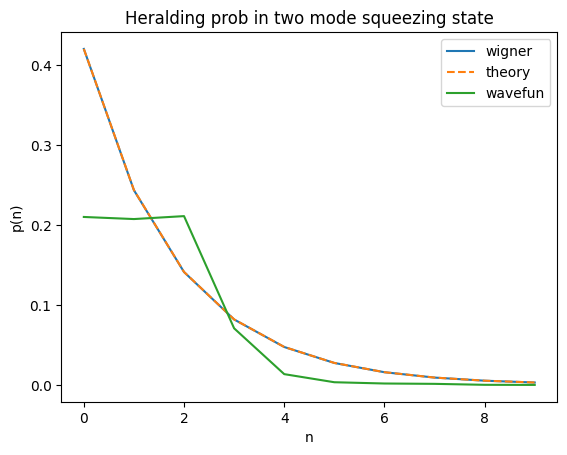

In [37]:
plt.plot(ns, ps,label='wigner')
plt.plot(ns,ptheory,label='theory',linestyle='dashed')
plt.plot(ns,pwave, label='wavefun',)
plt.legend()
plt.xlabel('n')
plt.ylabel('p(n)')
plt.title('Heralding prob in two mode squeezing state')
plt.show()

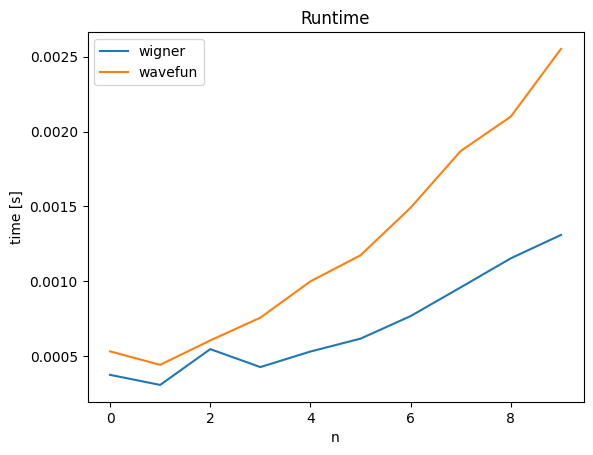

In [38]:
plt.plot(ns, twig,label='wigner')
plt.plot(ns, twave, label='wavefun',)
plt.legend()
plt.xlabel('n')
plt.ylabel('time [s]')
plt.title('Runtime')
plt.show()

In [40]:
## Comments: Wavefun taking longer isn't surprising, since the probability calc is currently in a for-loop